## ESC-50 + VGGish Audio Classifier

In [ ]:
# Setup
!pip install tensorflow tensorflow-hub librosa pandas scikit-learn -q

import os
import zipfile
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [20]:
# Download ESC-50 dataset
!wget -q --show-progress https://github.com/karoldvl/ESC-50/archive/master.zip -O esc50.zip
with zipfile.ZipFile("esc50.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

meta = pd.read_csv("ESC-50-master/meta/esc50.csv")
audio_path = "ESC-50-master/audio"

# Load VGGish pretrained model
vggish_model = hub.load("https://tfhub.dev/google/vggish/1")

# function to get embedding
def extract_vggish_embedding(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=16000, mono=True)
        audio = audio[:sr*5]  # take first 5s max
        audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)
        embeddings = vggish_model(audio_tensor)
        return tf.reduce_mean(embeddings, axis=0).numpy()
    except Exception as e:
        print(f"Error {file_path}: {e}")
        return None

# Prepare dataset
subset_size = 2000
sample_meta = meta.head(subset_size)

X, y = [], []
for idx, row in sample_meta.iterrows():
    fpath = os.path.join(audio_path, row["filename"])
    emb = extract_vggish_embedding(fpath)
    if emb is not None:
        X.append(emb)
        y.append(row["category"])

X = np.array(X)
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Classifier
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=8, verbose=1)

# Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {acc:.2f}")

# Demo prediction
import random
idx = random.choice(range(len(X_test)))
pred = model.predict(X_test[idx:idx+1])
print("True:", le.inverse_transform([np.argmax(y_test[idx])])[0])
print("Pred:", le.inverse_transform([np.argmax(pred)])[0])


esc50.zip           100%[===================>] 615.78M  17.4MB/s    in 38s     


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,962 (89.70 KB)

 Trainable params: 22,962 (89.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1169 - loss: 3.6538 - val_accuracy: 0.4450 - val_loss: 2.5094
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4126 - loss: 2.3263 - val_accuracy: 0.5350 - val_loss: 1.8707
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5552 - loss: 1.7338 - val_accuracy: 0.5650 - val_loss: 1.6197
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6019 - loss: 1.4462 - val_accuracy: 0.6350 - val_loss: 1.4283
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6484 - loss: 1.2770 - val_accuracy: 0.6200 - val_loss: 1.3477
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6584 - loss: 1.2374 - val_accuracy: 0.6550 - val_loss: 1.2633
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7045 - loss: 1.0488 - val_accuracy: 0.6525 - val_loss: 1.1914
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7045 - loss: 0.9951 - val_accuracy: 0.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


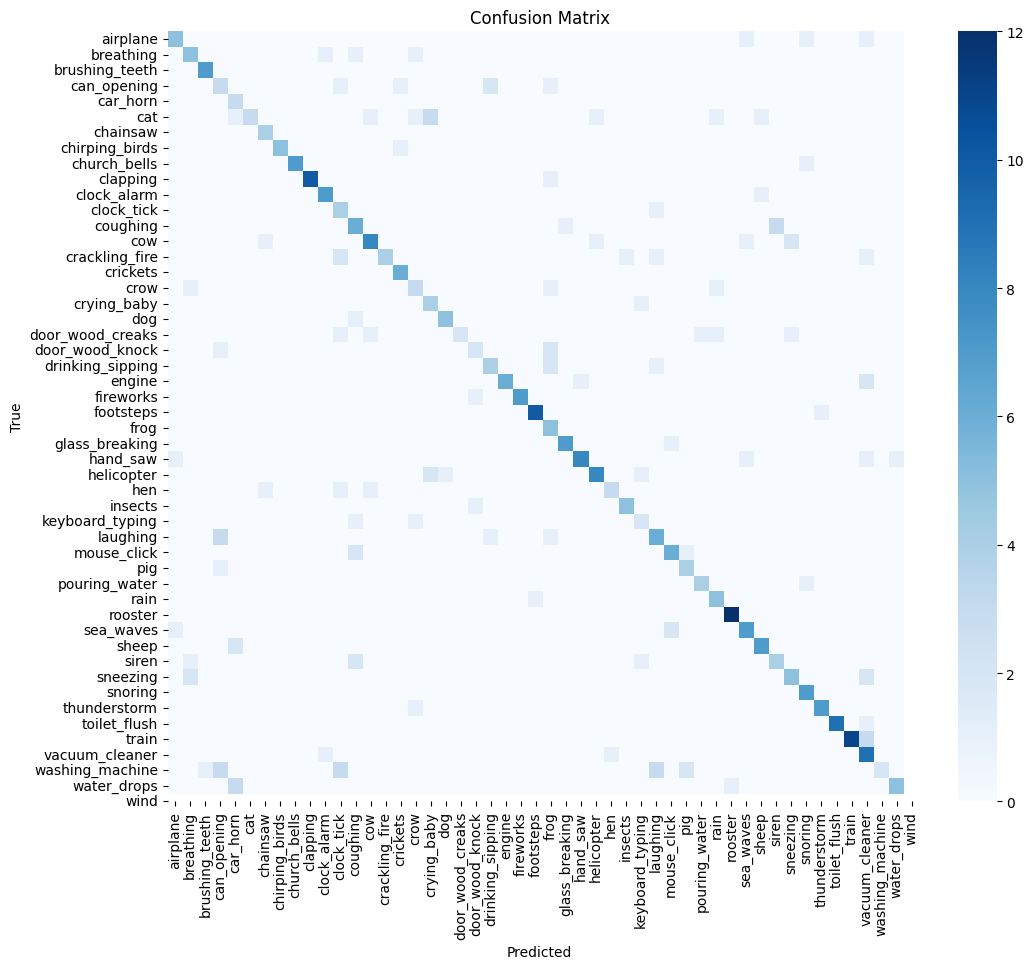

In [23]:
# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

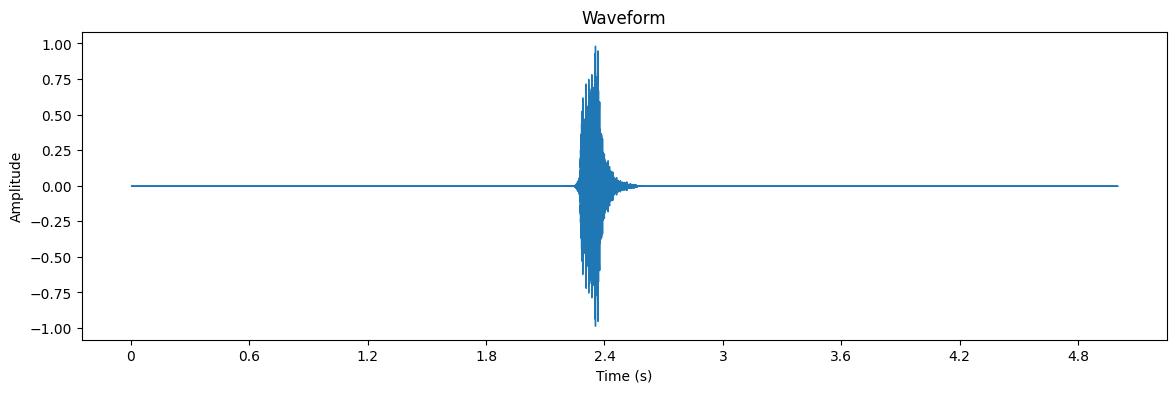

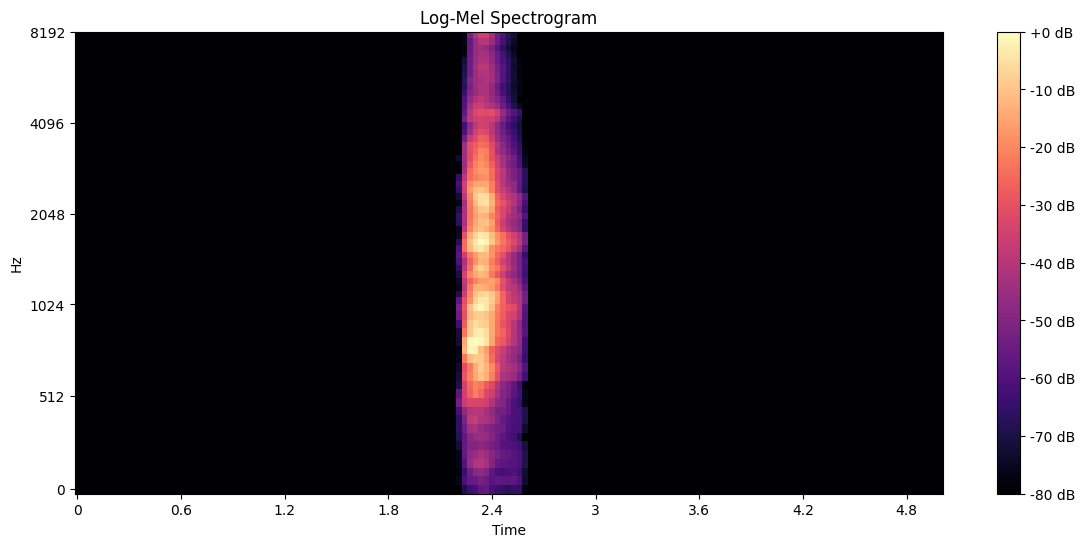

This mel spectrogram is what VGGish uses internally to extract embeddings (in 0.96s patches).


In [24]:
# Visualization: waveform and mel spectrogram
example_file = os.path.join(audio_path, sample_meta.iloc[0]["filename"])
audio, sr = librosa.load(example_file, sr=16000, mono=True)


plt.figure(figsize=(14, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


# Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=64, fmax=8000)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)


plt.figure(figsize=(14, 6))
librosa.display.specshow(log_mel_spec, sr=sr, x_axis="time", y_axis="mel", fmax=8000)
plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram")
plt.show()


print("This mel spectrogram is what VGGish uses internally to extract embeddings (in 0.96s patches).")